<a href="https://colab.research.google.com/github/olinml2024/notebooks/blob/main/ML24_Assignment07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autograd

**High-level picture:** In this assignment you'll be implementing your very own system for automatic differentiation.  You'll then see how this framework can be used for solving a range of machine learning problems by using your autograd engine within a gradient descent optimizer.  We'll conclude by comparing the system your autograd engine with the popular machine learning library `pytorch`.

Credits: the design of the autograd engine you will be implementing is based on the micrograd framework from Andrej Karpathy.  You may find it useful [to watch Andrej Karpathy's walkthrough video](https://www.youtube.com/watch?v=VMj-3S1tku0&t=2414s) of this.  A lot of what we've done in the first 2/3 of the assignment follows along the same lines, but we felt it important to explicitly define exercises so that you are actively doing things and reasoning about what you are implementing rather than just passively watching.

1. Recall the definition of a derivative and a partial derivative and how it can be approximated numerically.  Test on a simple function and make sure the calculus and the numerical approximation agree.

2. Create a `Value` class that provides represents a scalar value.  Define an addition function that allows you to add Value objects together.  Keep a placeholder to store, as a Python `set`, the Values that feed into the returned value.  When you define your addition function call, define it is `__add__(self, other)` so you can use the syntax `a+b` to add two value objects.  Test your class on some simple inputs.

3. Add a multiplication function to your class.  You can copy-paste your code from 2 so you still have a record of how your code was on exercise 2.  Test this on a simple expression.

4. Draw a dataflow diagram representing `x*y + z*z*x` (involving additions and multiplications).  Work out the partial derivatives.

5. Add the provided template code (`draw_dot`, `trace`, and an import statement) and use it to draw the dataflow diagram automatically.  You'll need to add a string `_op` that describes the operation for your `Value` object for the purposes of this visualization.  You may need to adjust the draw_dot function based on the variable names you chose for your Value class.  Feel free to set the vaues for x, y, and z to whatever you'd like.

6. Add a placeholder to store a partial derivative with our value function (let's call this variable `grad` in your `Value` class).  It will represent the partial derivative of the final expression with respect to the value.  By default it should have the value 0.  We'll give you a template for the `_backward()` function and you will fill in the blanks for addition and multiplication.  This should follow the same template as what we did in class last time.  Test your function by defining values to represent `x` and `y` and then computing `z = x*y`.  Call `_backward` on the x, y, and z in an appropriate order (you decide) and then make sure the values of `x.grad`, `y.grad`, and `z.grad` are correct.

6. Add support for the sigmoid function and log loss.  Come up with a suitable test case for your new function and make sure that your implementation agrees with what you expect.  Make sure that the output and `grad` are computed appropriately.  Note: you should choose something pretty simple here. Avoid doing more than one operation in a single assignment as that will make it hard to properly call `_backward()` (i.e., don't do ``z =(x*y+z).sigmoid()`).  If you'd like, we have provided an updated `draw_dot` function to visualize `grad`.

7. Add the backward function that we provide (or implement it if you want).  We'll explain what's happening.  Students will explain why the reverse topological sort is necessary.

8. Use the `backward` function to evaluate the partial derivatives of $f = xy + z^2x$ with respect to $x$, $y$, and $z$.

9. Implement a logistic regression model on the Titanic dataset.  Use a fixed learning rate.  We'll provide a reference implementation in Pytorch.  Make sure they converge to the same thing.  We'll provide starter code that downloads the data and creates a model of the form $p(survival) = \sigma(w_1 \times sex + w_2 \times age + w_3)$ (you can think of $w_3$ as our constant offset).

10. (bonus) experiment with different learning rates or learning rate schedules to see how it changes the speed at which the model converges.

**Exercise 1 Solution**

In [148]:
from math import sin, cos

def f(x):
    return x**2 + 5*x

def df(x):
    return 2*x + 5

x = 3
h = 0.001

df_approx = (f(x+h) - f(x))/h

print(f"derivative using calculus {df(x)} approximation of derivative {df_approx}")

def g(x,y):
    return sin(x)*y**2

def dg_dx(x,y):
    return cos(x)*y**2

def dg_dy(x,y):
    return 2*y*sin(x)

x = 2
y = 1

dg_dx_approx = (g(x+h,y) - g(x,y))/h
dg_dy_approx = (g(x,y+h) - g(x,y))/h

print(f"derivative using calculus {dg_dx(x,y)} approximation of derivative {dg_dx_approx}")
print(f"derivative using calculus {dg_dy(x,y)} approximation of derivative {dg_dy_approx}")

derivative using calculus 11 approximation of derivative 11.00100000000026
derivative using calculus -0.4161468365471424 approximation of derivative -0.416601415864859
derivative using calculus 1.8185948536513634 approximation of derivative 1.8195041510778998


**Exercise 2 Solution**

In [149]:
class Value:
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)

    def __add__(self, other):
        return Value(self.data + other.data, (self, other))

x = Value(3)
y = Value(7)
z = x + y
print(z.data)       # should be 10

10


**Exercise 3 Solution**

In [150]:
class Value:
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children)

    def __add__(self, other):
        return Value(self.data + other.data, (self, other))

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other))

q = Value(2) * Value(3)
print(q.data)           # should be 6

6


**Exercise 4 Solution**

This one is pen and paper, need to work this one out.

**Exercise 5 Solution**

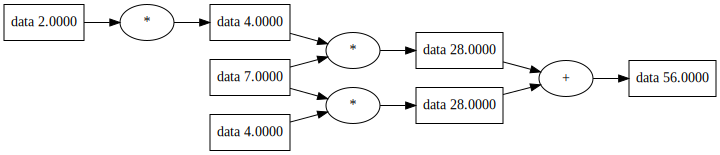

In [151]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

class Value:
    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')


x = Value(7)
y = Value(4)
z = Value(2)
q = x*y + z*z*x
draw_dot(q)

**Exercise 6**

8
3
1


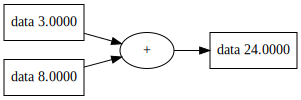

In [152]:
class Value:
    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda : None
        self.grad = 0

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '+')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

x = Value(3)
y = Value(8)
z = x*y

z.grad = 1
z._backward()
y._backward()
x._backward()

print(x.grad)
print(y.grad)
print(z.grad)
draw_dot(z)

**Exercise 7 Solution**

0.9525741268224334
0.04858735157374191
-0.047425873177566635


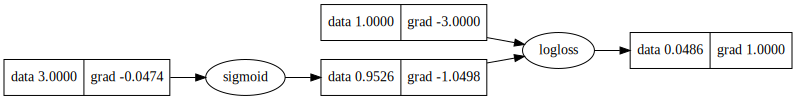

In [153]:
from math import exp, log
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
class Value:
    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda : None
        self.grad = 0

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '+')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def sigmoid(self):
        out = Value(1./(1+exp(-self.data)), _children=(self,), _op='sigmoid')
        def _backward():
            self.grad += out.grad * out.data * (1 - out.data)
        out._backward = _backward
        return out

    def logloss(self, y):
        out = Value(-y.data*log(self.data) - (1-y.data)*log(1-self.data), (self, y), 'logloss')
        def _backward():
            self.grad += out.grad * (-y.data/self.data + (1-y.data)/(1-self.data))
            y.grad += out.grad * (-y.data*log(self.data)+log(1-self.data))

        out._backward = _backward
        return out

x = Value(3)
z = x.sigmoid()
y = Value(1.0)
log_loss = z.logloss(y)
print(f"{z.data}")       # this should be 1/(1+exp(-3)) = 0.9525741268224334
print(f"{log_loss.data}")       # this should be -log(0.9525741268224334) = 0.04858735157374191(note: log is natural log)
log_loss.grad = 1
log_loss._backward()
z._backward()
y._backward()
x._backward()
print(f"{x.grad}")      # TODO: what should this be?
draw_dot(log_loss)

**Exercise 8 Solution**

In [159]:


class Value:
    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda : None
        self.grad = 0

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '+')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def sigmoid(self):
        out = Value(1./(1+exp(-self.data)), _children=(self,), _op='sigmoid')
        def _backward():
            self.grad += out.grad * out.data * (1 - out.data)
        out._backward = _backward
        return out

    def logloss(self, y):
        out = Value(-y.data*log(self.data) - (1-y.data)*log(1-self.data), (self, y), 'logloss')
        def _backward():
            self.grad += out.grad * (-y.data/self.data + (1-y.data)/(1-self.data))
            y.grad += out.grad * (-y.data*log(self.data)+log(1-self.data))
        out._backward = _backward
        return out

    def backward(self):
        # set our base case
        self.grad = 1
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

# we need to do a reverse topological sort so we don't call v._backward() on a
# value before the parent node has had v._backwardD() called

**Exercise 9 Solution**

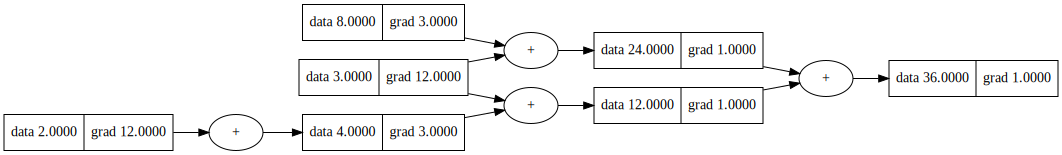

In [160]:
x = Value(3)
y = Value(8)
z = Value(2)
f = x*y + z*z*x
f.backward()
draw_dot(f)
# see drawing (df_dz should be 2*z*x = 12, df_dx should be y+z^2=12, df_dy should be x=3)

**Exercise 10 Solution**

In [161]:
import gdown
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Note: this is starter code
gdown.download(id='1kTOn_DDKZANTyb4H9thytr64xzqdm23y', output='titanic_train.csv')
titanic_df = pd.read_csv('titanic_train.csv')

titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Sex'].fillna(titanic_df['Sex'].mean(), inplace=True)
titanic_df
X = np.vstack((titanic_df['Age'],
               titanic_df['Sex'].map(lambda x: 1 if x == 'female'  else 0).T)).astype(np.float64)
X = np.vstack((X, np.ones((1, X.shape[1])))).T
y = np.asarray(titanic_df['Survived']).astype(np.float64)
print(f"X={X}, y={y}")

Downloading...
From: https://drive.google.com/uc?id=1kTOn_DDKZANTyb4H9thytr64xzqdm23y
To: /content/titanic_train.csv
100%|██████████| 61.2k/61.2k [00:00<00:00, 41.0MB/s]

X=[[22.          0.          1.        ]
 [38.          1.          1.        ]
 [26.          1.          1.        ]
 ...
 [29.69911765  1.          1.        ]
 [26.          0.          1.        ]
 [32.          0.          1.        ]], y=[0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 

In [191]:
# Note: this is starter code
from math import sqrt

w_1 = Value(0.0)
w_2 = Value(0.0)
w_3 = Value(-0.47)
learning_rate = 0.000001
grad_mag = float('1000000.0')

while grad_mag > 0.001:
    # reset everything
    total_loss = Value(0.0)
    w_1.grad = 0.0
    w_2.grad = 0.0
    w_3.grad = 0.0
    for i in range(X.shape[0]):
        # STUDENTS WILL FILL OUT THIS PART (between the two comments)
        s = w_1*Value(X[i,0]) + w_2*Value(X[i,1]) + w_3*Value(X[i,2])
        p = s.sigmoid()
        loss = p.logloss(Value(y[i]))
        total_loss = total_loss + loss
        # END STUDENT PART TO FILL OUT
    total_loss.backward()
    w_1.data -= w_1.grad*learning_rate
    w_2.data -= w_2.grad*learning_rate
    w_3.data -= w_3.grad*learning_rate
    grad_mag = sqrt(w_1.grad**2 + w_2.grad**2 + w_3.grad**2)

    print(f"total_loss {total_loss.data} grad_mag {grad_mag} w_1.data {w_1.data} w_2.data {w_2.data} w_3.data {w_3.data}")
# this is not converging as fast as desired

total_loss 593.3287075774832 grad_mag 428.6127866717092 w_1.data -0.000413657775859073 w_2.data 0.00011223049950683119 w_3.data -0.4700006930730554
total_loss 593.1638404612856 grad_mag 341.6545571141206 w_1.data -0.0007360477965112026 w_2.data 0.00022531877121352074 w_3.data -0.46999880792500837
total_loss 593.0584936871559 grad_mag 276.127118354158 w_1.data -0.0009876256169980833 w_2.data 0.0003390715092584487 w_3.data -0.469994922012384
total_loss 592.9891407971802 grad_mag 227.41153622677453 w_1.data -0.0011841688264397606 w_2.data 0.00045333948144200945 w_3.data -0.46998948104147403
total_loss 592.941609126703 grad_mag 191.88627237947273 w_1.data -0.0013378809762946509 w_2.data 0.0005680071733082245 w_3.data -0.46998282995458907
total_loss 592.9073332395984 grad_mag 166.61258436126434 w_1.data -0.0014582229670774389 w_2.data 0.0006829849751520426 w_3.data -0.4699752362990044
total_loss 592.8811229513965 grad_mag 149.1338754408571 w_1.data -0.0015525431698423335 w_2.data 0.00079820

KeyboardInterrupt: 

In [187]:
1./(1+exp(0.47))

0.38461624360881785

In [180]:
y.mean()

0.3838383838383838